In [2]:
import pandas as pd
import numpy as np
import glob
from dateutil.parser import parse
from pm4py.objects.log.obj import EventLog, Trace, Event
import pm4py
import pm4py.objects.log.util.sorting as sorting



In [4]:
path = "/Users/ethanjohnson/Desktop/mphil-project/raw_data/fake_news"

all_files = glob.glob(path + "/*.xlsx")
li = []
for filename in all_files:
    df = pd.read_excel(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)



In [5]:
processed_df = df.loc[:, ['ID', 'Date&Time', 'Retweet ID', 'Quote ID', 'Reply ID']]

# format Date&Time column
timestamps = processed_df['Date&Time']


new_timestamp = [word.replace("'", "") for word in timestamps]
new_timestamp = [word.replace("[", "") for word in new_timestamp]
new_timestamp = [word.replace("]", "") for word in new_timestamp]
new_timestamp = [parse(timestamp) for timestamp in new_timestamp]

processed_df['Date&Time'] = new_timestamp
processed_df = processed_df.rename(columns={'Date&Time':'timestamp', 'ID':'user_id', 'Retweet ID':'retweet_id', 
                                            'Quote ID': 'quote_id', 'Reply ID':'reply_id'})
processed_df['user_id'] = processed_df['user_id'].astype('str')
processed_df['reply_id'] = processed_df['reply_id'].astype('str')

print(processed_df)

                 user_id           timestamp           retweet_id  \
0               86796377 2018-02-07 10:19:00        Not a Retweet   
1     958643050573688832 2018-02-07 09:44:05   961162572056719360   
2     817588523385651200 2018-02-07 09:13:27   961128437359566848   
3             1441272361 2018-02-07 08:59:49        Not a Retweet   
4             2797399794 2018-02-07 08:49:52        Not a Retweet   
...                  ...                 ...                  ...   
4039            63910001 2018-08-09 18:18:43  1027620097244848128   
4040            25675732 2018-08-09 18:18:42  1027620097244848128   
4041  709509298653626368 2018-08-09 18:18:39  1027620097244848128   
4042            18461442 2018-08-09 18:18:32  1027620097244848128   
4043            16812908 2018-08-09 18:18:27  1027620097244848128   

         quote_id reply_id  
0     Not a quote      nan  
1     Not a quote      nan  
2     Not a quote      nan  
3     Not a quote      nan  
4     Not a quote      nan

In [6]:
# look through data frame
# collect all instances of single post in retweet, add users to trace
# repeat for reply, quote

# get all tweet ids

rt_id = processed_df['retweet_id'].unique()
rt_id = np.delete(rt_id, 0)

qt_id = processed_df['quote_id'].unique()
qt_id = np.delete(qt_id, 0)

rp_id = processed_df['reply_id'].unique()
rp_id = np.delete(rp_id, 0)


all_id = np.concatenate((rt_id, qt_id, rp_id))
all_id = np.unique(all_id)


# uses specific tweet id to get all actions related to tweet
actions = ['retweet', 'quote', 'reply']
post_log = EventLog()


for id in all_id:
    trace = Trace()
    for action in actions:
        action_events = processed_df.loc[processed_df[action+'_id']==id]
        for i in range(len(action_events)):
            event = Event({'concept:name' : action_events.iat[i,0] + '-' + action + 's', 'time:timestamp' : action_events.iat[i,1]})

            trace.insert(i, event)
    trace = sorting.sort_timestamp_trace(trace)
    post_log.append(trace)

post_log = pm4py.convert_to_event_log(post_log)

pm4py.write_xes(post_log, '/Users/ethanjohnson/Desktop/mphil-project/processed_data/post_centric_log.xes')
        

/Users/ethanjohnson/.local/share/virtualenvs/mphil-project-KaAb4vnI/lib/python3.10/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/ethanjohnson/.local/share/virtualenvs/mphil-project-KaAb4vnI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
exporting log, completed traces :: 100%|██████████| 321/321 [00:00<00:00, 11334.72it/s]


In [7]:
post_log = pm4py.filter_case_size(post_log, 2, 2**50)

print('discovering...')
net, im, fm = pm4py.discover_petri_net_inductive(post_log)

print('visualising...')
pm4py.view_petri_net(net, im, fm)

discovering...


/Users/ethanjohnson/.local/share/virtualenvs/mphil-project-KaAb4vnI/lib/python3.10/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


KeyboardInterrupt: 

In [8]:
# take all instances of single user where they retweet add to trace
# repeat for reply, quote
# if no value in any of these it is a post

user_log = EventLog()

user_id = processed_df['user_id'].unique()
  

for id in user_id:
    trace = Trace()
    user_events = processed_df.loc[processed_df['user_id']==id]

    for i in range(len(user_events)):
        if user_events.iat[i,2]!='Not a Retweet':
            event = Event({'concept:name':'retweet', 'time:timestamp' : user_events.iat[i,1]})
        elif user_events.iat[i,3] != 'Not a quote':
            event = Event({'concept:name':'quote', 'time:timestamp' : user_events.iat[i,1]})
        elif user_events.iat[i,4]!= 'nan':
            event = Event({'concept:name':'reply', 'time:timestamp' : user_events.iat[i,1]})
        else:
            event = Event({'concept:name':'post', 'time:timestamp' : user_events.iat[i,1]})
        trace.insert(i, event)
    trace = sorting.sort_timestamp_trace(trace)
    user_log.append(trace)

user_log = pm4py.convert_to_event_log(user_log)

pm4py.write_xes(user_log, '/Users/ethanjohnson/Desktop/mphil-project/processed_data/user_centric_log.xes')


exporting log, completed traces :: 100%|██████████| 3798/3798 [00:00<00:00, 93424.86it/s]


discovering...
visualising...


/Users/ethanjohnson/.local/share/virtualenvs/mphil-project-KaAb4vnI/lib/python3.10/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


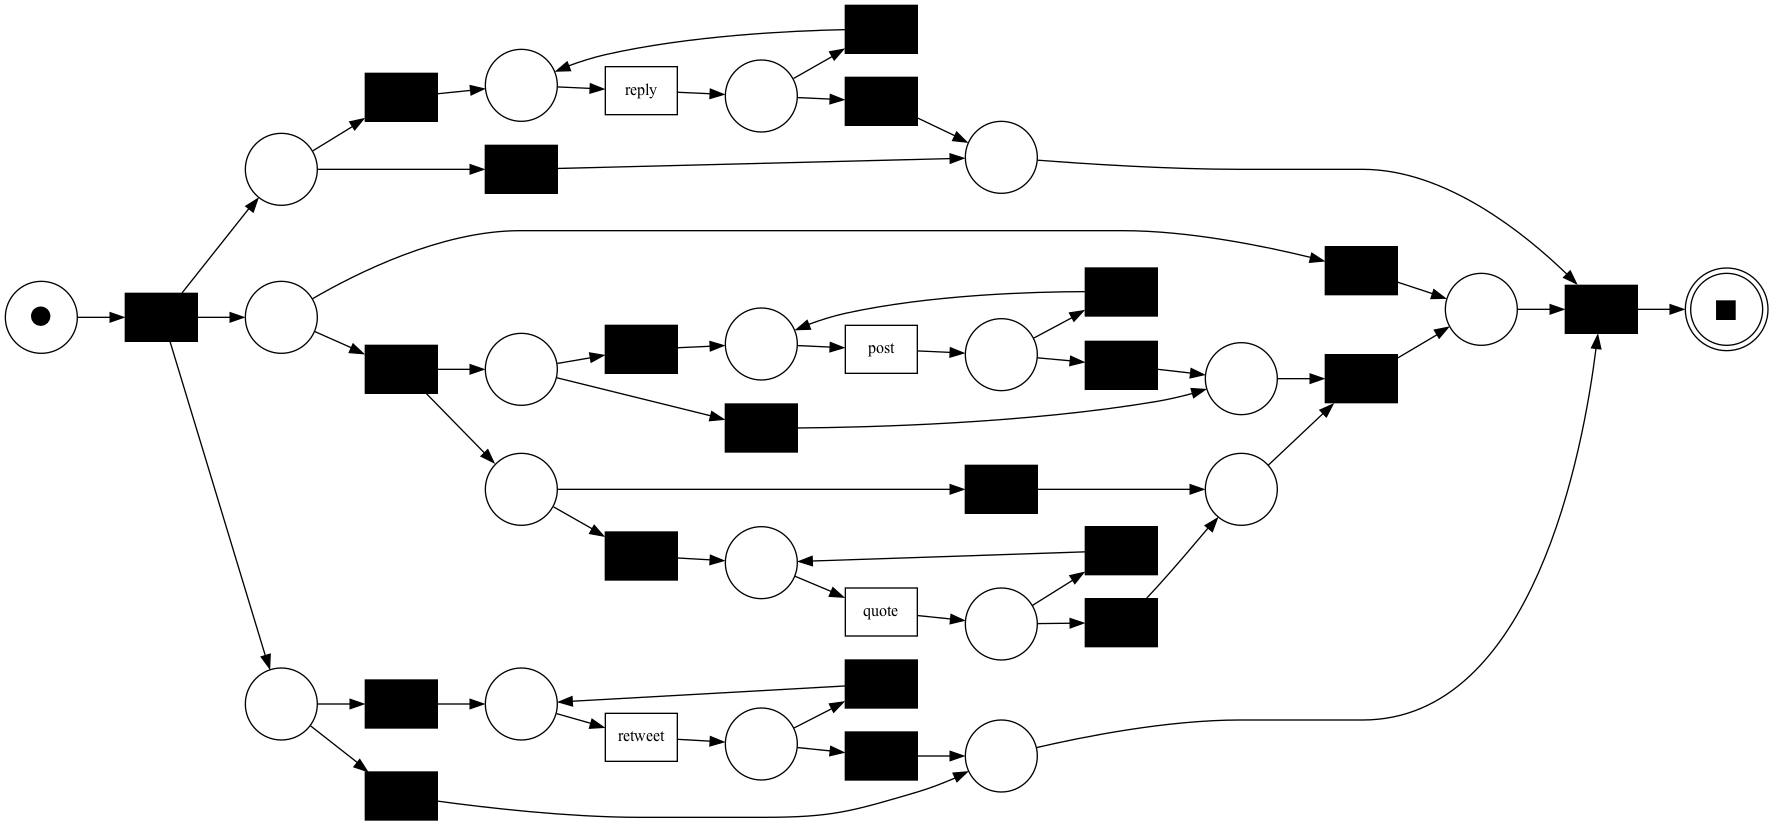

In [10]:
user_log = pm4py.filter_case_size(user_log, 2, 2**50)

print('discovering...')
net, im, fm = pm4py.discover_petri_net_inductive(user_log)

print('visualising...')
pm4py.view_petri_net(net, im, fm)